In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch_geometric.data import Data
from scipy.sparse import coo_matrix
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from torch_geometric.nn import NNConv, GCNConv, global_mean_pool

# Visualization
import matplotlib.pyplot as plt

# Import Data

In [6]:
# List of file paths
file_paths = [
    '../data/ASPEDv1.1-flow/523_flow_final.csv',
    '../data/ASPEDv1.1-flow/601_flow_final.csv',
    '../data/ASPEDv1.1-flow/607_flow_final.csv',
    '../data/ASPEDv1.1-flow/621_flow_final.csv',
    '../data/ASPEDv1.1-flow/628_flow_final.csv'
]

def convert_datetime(column):
    formats = ['%Y-%m-%d %H:%M:%S', '%m/%d/%Y %H:%M:%S', '%d-%m-%Y %H:%M', ...]  # List all expected formats

    for fmt in formats:
        try:
            return pd.to_datetime(column, format=fmt)
        except ValueError:
            continue
    return pd.to_datetime(column, errors='coerce')  # Fallback to coercion in case all formats fail

def load_data(file_path):
    df = pd.read_csv(file_path)
    df['timestamp'] = convert_datetime(df['timestamp'])
    return df

dataframes = [load_data(file) for file in file_paths]
combined_data = pd.concat(dataframes, ignore_index=True)

In [7]:
combined_data.head()

,timestamp,frame,recorder1_1m,recorder2_1m,recorder3_1m,recorder4_1m,recorder5_1m,recorder6_1m,recorder1_3m,recorder2_3m,...,recorder1_9m,recorder2_9m,recorder3_9m,recorder4_9m,recorder5_9m,recorder6_9m,Incremental_DOWN,Incremental_UP,Total_DOWN,Total_UP
0,2023-05-24 11:33:00,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
1,2023-05-24 11:33:01,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,2023-05-24 11:33:02,2,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,2023-05-24 11:33:03,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2023-05-24 11:33:04,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
# Import pedestrian data
#cadell524 = pd.read_csv("./ASPEDv1.1/5-24-Cadell-merged.csv")

# Dropping 1, 3, and 9m columns for simplicity.
del_cols = []
num_locations = 6

for loc in range(1, num_locations +1):
    for meter in ['1m', '3m', '6m']:
        del_cols.append(f'recorder{loc}_{meter}')

combined_data = combined_data.drop(del_cols, axis=1)

recorder_columns = ['recorder1', 'recorder2', 'recorder3', 'recorder4', 'recorder5', 'recorder6']
    
combined_data.columns = ["timestamp", "frame", "recorder1", "recorder2", "recorder3", "recorder4", "recorder5", "recorder6", 
                         "Incremental_DOWN", "Incremental_UP", "Total_DOWN", "Total_UP"]


combined_data.head()

,timestamp,frame,recorder1,recorder2,recorder3,recorder4,recorder5,recorder6,Incremental_DOWN,Incremental_UP,Total_DOWN,Total_UP
0,2023-05-24 11:33:00,0,0,1,0,0,1,0,0,0,0,0
1,2023-05-24 11:33:01,1,0,1,0,0,0,0,0,0,0,0
2,2023-05-24 11:33:02,2,0,0,1,0,0,0,0,0,0,0
3,2023-05-24 11:33:03,3,0,0,0,0,0,0,0,0,0,0
4,2023-05-24 11:33:04,4,0,0,0,0,0,0,0,0,0,0


In [9]:
# Filter out rows where time is not between 7 AM and 7 PM
# Ensure 'timestamp' is a datetime object
combined_data['timestamp'] = pd.to_datetime(combined_data['timestamp'])

# Filtering out rows between 7 PM (19:00) to 7 AM (07:00)
combined_data = combined_data[
    (combined_data['timestamp'].dt.hour >= 7) & (combined_data['timestamp'].dt.hour < 19)
]

print(combined_data.shape)

(378548, 12)


In [10]:
# Ensure the timestamp column is in datetime format
combined_data['timestamp'] = pd.to_datetime(combined_data['timestamp'])
combined_data['hour'] = combined_data['timestamp'].dt.hour
combined_data['day_of_week'] = combined_data['timestamp'].dt.dayofweek

combined_data.head()

,timestamp,frame,recorder1,recorder2,recorder3,recorder4,recorder5,recorder6,Incremental_DOWN,Incremental_UP,Total_DOWN,Total_UP,hour,day_of_week
0,2023-05-24 11:33:00,0,0,1,0,0,1,0,0,0,0,0,11,2
1,2023-05-24 11:33:01,1,0,1,0,0,0,0,0,0,0,0,11,2
2,2023-05-24 11:33:02,2,0,0,1,0,0,0,0,0,0,0,11,2
3,2023-05-24 11:33:03,3,0,0,0,0,0,0,0,0,0,0,11,2
4,2023-05-24 11:33:04,4,0,0,0,0,0,0,0,0,0,0,11,2


# Aggregate to N second average chunks

In [11]:
# Sample DataFrame creation
# Assuming 'timestamp' is a column with datetime data on second intervals
combined_data['timestamp'] = pd.date_range(start='2023-05-24 11:33:00', periods=len(combined_data), freq='S')
combined_data.set_index('timestamp', inplace=True)

# Define custom aggregation functions for each column
aggregations = {
    'recorder1': 'mean',  # Replace 'location1' to 'location6' with your actual column names
    'recorder2': 'mean',
    'recorder3': 'mean',
    'recorder4': 'mean',
    'recorder5': 'mean',
    'recorder6': 'mean',
    'hour': 'first',
    'day_of_week': 'first',
    'Incremental_UP': 'sum',
    'Incremental_DOWN': 'sum',
    'Total_UP': 'mean',
    'Total_DOWN': 'mean'
}

# Resample and compute the mean for each 5-second interval
aggregated_data_2s = combined_data.resample('2S').agg(aggregations)
aggregated_data_3s = combined_data.resample('3S').agg(aggregations)
aggregated_data_5s = combined_data.resample('5S').agg(aggregations)
aggregated_data_10s = combined_data.resample('10S').agg(aggregations)

# Reset the index if you want 'timestamp' back as a column
aggregated_data_2s.reset_index(inplace=True)
aggregated_data_3s.reset_index(inplace=True)
aggregated_data_5s.reset_index(inplace=True)
aggregated_data_10s.reset_index(inplace=True)

# Now, aggregated_data holds the averaged values for each 5-second chunk
aggregated_data_2s.head()

/var/folders/v5/9zhxcvtx7rd3kvh2dpmps8wr0000gn/T/ipykernel_89171/880490792.py:3: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  combined_data['timestamp'] = pd.date_range(start='2023-05-24 11:33:00', periods=len(combined_data), freq='S')
/var/folders/v5/9zhxcvtx7rd3kvh2dpmps8wr0000gn/T/ipykernel_89171/880490792.py:23: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  aggregated_data_2s = combined_data.resample('2S').agg(aggregations)
/var/folders/v5/9zhxcvtx7rd3kvh2dpmps8wr0000gn/T/ipykernel_89171/880490792.py:24: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  aggregated_data_3s = combined_data.resample('3S').agg(aggregations)
/var/folders/v5/9zhxcvtx7rd3kvh2dpmps8wr0000gn/T/ipykernel_89171/880490792.py:25: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  aggregated_data_5s = combin

,timestamp,recorder1,recorder2,recorder3,recorder4,recorder5,recorder6,hour,day_of_week,Incremental_UP,Incremental_DOWN,Total_UP,Total_DOWN
0,2023-05-24 11:33:00,0.0,1.0,0.0,0.0,0.5,0.0,11,2,0,0,0.0,0.0
1,2023-05-24 11:33:02,0.0,0.0,0.5,0.0,0.0,0.0,11,2,0,0,0.0,0.0
2,2023-05-24 11:33:04,0.5,0.0,0.0,0.0,0.0,0.0,11,2,0,0,0.0,0.0
3,2023-05-24 11:33:06,1.0,0.0,0.5,0.0,0.0,0.0,11,2,0,0,0.0,0.0
4,2023-05-24 11:33:08,3.0,0.0,0.0,0.0,0.0,0.0,11,2,0,0,0.0,0.0


In [36]:
# 'timestamp' is the first column and the rest are recorder counts
timestamps_2s = aggregated_data_2s['timestamp']
timestamps_3s = aggregated_data_3s['timestamp']
timestamps_5s = aggregated_data_5s['timestamp']
timestamps_10s = aggregated_data_10s['timestamp']

# Selecting features for the model
date_columns = ['hour'] 

simple = False
if simple:
    recorder_columns = ['recorder1','recorder2', 'recorder5']
else:
    recorder_columns = ['recorder1', 'recorder2', 'recorder3', 'recorder4', 'recorder5', 'recorder6']
    
video_columns = ['Incremental_UP', 'Incremental_DOWN']
target_columns = ['Incremental_UP', 'Incremental_DOWN']

In [71]:
data = aggregated_data_5s

In [72]:
# Create the feature (X) and target (Y) tensor
all_features = data[recorder_columns + date_columns + video_columns]
target_features = data[target_columns]

all_features_tensor = torch.tensor(all_features.values, dtype=torch.float)
target_tensor = torch.tensor(target_features.values, dtype=torch.float)

# Data Preparation - Normalization and Train-Test Split

In [73]:
# Min-max scaling of features (pedestrian counts)
all_features_np = all_features_tensor.numpy()
target_np = target_tensor.numpy()

def min_max_scale(data):
    data_min = np.min(data, axis=0)
    data_max = np.max(data, axis=0)
    return (data - data_min) / (data_max - data_min), data_min, data_max

scaled_features, features_min, features_max = min_max_scale(all_features_np)
scaled_targets, targets_min, targets_max = min_max_scale(target_np)

In [74]:
print("Min of features:", features_min)
print("Max of features:", features_max)
print("Min of targets:", targets_min)
print("Max of features:", targets_max)

Min of features: [0. 0. 0. 0. 0. 0. 7. 0. 0.]
Max of features: [17.8 10.6 17.6 10.2 10.2 14.2 18.   5.   6. ]
Min of targets: [0. 0.]
Max of features: [5. 6.]


### Make Sequential Data for Time Series Prediction

In [18]:
scaled_features[0]

array([0.        , 0.03773585, 0.01960784, 0.36363637, 0.        ,
       0.        ], dtype=float32)

In [75]:
# Define sequence length
sequence_length = 10  # 10 time steps per sequence
date_id = 7

def create_feature_target_sequences(data, target_data, seq_length):
    xs = []
    ys = []
    for i in range(len(data) - seq_length):
        # Check if the time of day is continuous
        time_of_day_seq = data[i:(i + seq_length), date_id-1]  # Assuming the time of day is the last feature (4th feature)
        
        # Compare consecutive time steps, check if they are 1 unit apart
        if np.all(np.diff(time_of_day_seq) == 1) or np.all(np.diff(time_of_day_seq) == 0):
            # Add feature sequence
            xs.append(data[i:(i + seq_length)])
            
            # Add the corresponding target sequence
            summed_sequence = np.sum(target_data[i:(i + seq_length)], axis=0)
            ys.append(summed_sequence)
        
    return np.array(xs), np.array(ys)

# Assuming scaled_features contain the full set of features and scaled_targets is the target data
sequential_features, sequential_targets = create_feature_target_sequences(scaled_features, scaled_targets, sequence_length)

# Convert to tensor
# sequential_features_tensor = torch.tensor(sequential_features, dtype=torch.float)

# For predicting one step ahead
# sequential_target_tensor = torch.tensor(sequential_targets, dtype=torch.float)  # Use the last point in each sequence as target

print(len(sequential_features))
print(len(sequential_targets))

# Remove the last sequence from the feature tensor if its corresponding target does not exist
if len(sequential_features) > len(sequential_targets):
    sequential_features = sequential_features[:-1]

74719
74719


In [76]:
print(sequential_features[19111])
print(sequential_targets[19111])

[[0.         0.         0.         0.         0.         0.
  0.18181819 0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.18181819 0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.18181819 0.         0.        ]
 [0.         0.         0.         0.         0.         0.01408451
  0.18181819 0.         0.        ]
 [0.         0.         0.         0.         0.         0.02816902
  0.18181819 0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.18181819 0.         0.        ]
 [0.         0.         0.         0.         0.         0.02816902
  0.18181819 0.         0.        ]
 [0.         0.         0.         0.         0.         0.01408451
  0.18181819 0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.18181819 0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.18181819 0.         0.        ]]
[0. 0.]

# Split Dataset Train (60%), Validation (30%), Test (10%)

In [77]:
# Calculate the number of sequences in the dataset, same for audio and video
num_sequences = len(sequential_features)  

# Calculate the split index
split_index = int(num_sequences * 0.9)  # 60% of the data for training
print(split_index)

# Split the features 90%
trainvalid_features = sequential_features[:split_index]
test_features = sequential_features[split_index:]

# Split by audio and video
audio_trainvalid_features = trainvalid_features[:,:,:7]
video_trainvalid_features = trainvalid_features[:,:,6:]

audio_test_features = test_features[:,:,:7]
video_test_features = test_features[:,:,6:]

# Split the targets 10% 
trainvalid_targets = sequential_targets[:split_index]
test_targets = sequential_targets[split_index:]

print(f"Audio Training features shape: {audio_trainvalid_features.shape}")
print(f"Video Training features shape: {video_trainvalid_features.shape}")
print(f"Audio + Video Training features shape: {trainvalid_features.shape}")
print(f"Training targets shape: {trainvalid_targets.shape}")

print(f"Audio Testing features shape: {audio_test_features.shape}")
print(f"Video Testing features shape: {video_test_features.shape}")
print(f"Audio + Video Testing shape: {test_features.shape}")
print(f"Testing targets shape: {test_targets.shape}")

67247
Audio Training features shape: (67247, 10, 7)
Video Training features shape: (67247, 10, 3)
Audio + Video Training features shape: (67247, 10, 9)
Training targets shape: (67247, 2)
Audio Testing features shape: (7472, 10, 7)
Video Testing features shape: (7472, 10, 3)
Audio + Video Testing shape: (7472, 10, 9)
Testing targets shape: (7472, 2)


In [51]:
print("audio feature example: ")
print(audio_trainvalid_features[80])
print("video feature example: ")
print(video_trainvalid_features[80])
print("target example: ")
print(trainvalid_targets[80])

audio feature example: 
[[0.         0.         0.01136364 0.         0.         0.05633803
  0.36363637]
 [0.         0.         0.04545455 0.         0.         0.
  0.36363637]
 [0.         0.         0.03409091 0.         0.         0.
  0.36363637]
 [0.         0.         0.         0.         0.         0.
  0.36363637]
 [0.         0.         0.         0.         0.         0.
  0.36363637]
 [0.         0.         0.         0.         0.         0.
  0.36363637]
 [0.         0.         0.         0.         0.         0.
  0.36363637]
 [0.         0.         0.         0.         0.         0.
  0.36363637]
 [0.         0.         0.         0.         0.         0.
  0.36363637]
 [0.         0.         0.         0.         0.         0.
  0.36363637]]
video feature example: 
[[0.36363637 0.         0.        ]
 [0.36363637 0.         0.        ]
 [0.36363637 0.         0.        ]
 [0.36363637 0.         0.        ]
 [0.36363637 0.         0.        ]
 [0.36363637 0.        

# Balance Training and Validation Dataset

In [52]:
print(video_trainvalid_features[200][:, 1:])
np.sum(video_trainvalid_features[200][:, 1:])

[[0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.16666667]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]]


np.float32(0.16666667)

In [78]:
# Filter out sequences where all recorders have zero pedestrians across all 10 frames 
valid_indices = [i for i, seq in enumerate(video_trainvalid_features) if not np.sum(seq[:, 1:]) == 0]
zero_indices = [i for i, seq in enumerate(video_trainvalid_features) if np.sum(seq[:, 1:]) == 0]

# Use valid_indices to filter both features and targets
nonzero_audio_features = audio_trainvalid_features[valid_indices]
nonzero_video_features = video_trainvalid_features[valid_indices]
nonzero_features = trainvalid_features[valid_indices]
nonzero_targets = trainvalid_targets[valid_indices]

# Use valid_indices to filter both features and targets
allzero_audio_features = audio_trainvalid_features[zero_indices]
allzero_video_features = video_trainvalid_features[zero_indices]
allzero_features = trainvalid_features[zero_indices]
allzero_targets = trainvalid_targets[zero_indices]

In [79]:
# Determine the number of samples to take from each group
# num_samples = min(len(nonzero_features), len(allzero_features))
num_samples = len(nonzero_audio_features)
print("number of non-zero samples: ", num_samples)

print("length of Non-zero sequences: ", len(nonzero_audio_features))
print("length of All-zero sequences: ", len(allzero_audio_features))


number of non-zero samples:  24190
length of Non-zero sequences:  24190
length of All-zero sequences:  43057


In [80]:
# Generate random indices for sampling without replacement
zero_indices = np.random.choice(len(allzero_audio_features), int(num_samples/2), replace=False)

# non_zero_indices = np.random.choice(len(nonzero_audio_features), num_samples, replace=False)

# Sample features and targets based on the indices
allzero_audio_features_sampled = allzero_audio_features[zero_indices]
allzero_video_features_sampled = allzero_video_features[zero_indices]
allzero_features_sampled = allzero_features[zero_indices]

# nonzero_features_sampled = nonzero_features[non_zero_indices]

allzero_targets_sampled = allzero_targets[zero_indices]
# nonzero_targets_sampled = nonzero_targets[non_zero_indices]

print("length of Non-zero samples: ", len(nonzero_targets))
print("length of All-zero samples: ", len(allzero_targets_sampled))

# Combine the samples to form new feature and target sets
balanced_audio_features = np.concatenate([allzero_audio_features_sampled, nonzero_audio_features], axis=0)
balanced_video_features = np.concatenate([allzero_video_features_sampled, nonzero_video_features], axis=0)
balanced_features = np.concatenate([allzero_features_sampled, nonzero_features], axis=0)
balanced_targets = np.concatenate([allzero_targets_sampled, nonzero_targets], axis=0)

# Shuffle the combined dataset to randomize the order of sequences
# indices = np.arange(balanced_features.shape[0])
# np.random.shuffle(indices)
# balanced_features = balanced_features[indices]
# balanced_targets = balanced_targets[indices]

# Debugging and validation
print("Balanced audio features shape:", balanced_audio_features.shape)
print("Balanced video features shape:", balanced_video_features.shape)
print("Balanced audio + video features shape:", balanced_features.shape)
print("Balanced targets shape:", balanced_targets.shape)

length of Non-zero samples:  24190
length of All-zero samples:  12095
Balanced audio features shape: (36285, 10, 7)
Balanced video features shape: (36285, 10, 3)
Balanced audio + video features shape: (36285, 10, 9)
Balanced targets shape: (36285, 2)


In [81]:
balanced_audio_features_tensor = torch.tensor(balanced_audio_features, dtype=torch.float)
balanced_video_features_tensor = torch.tensor(balanced_video_features, dtype=torch.float)
balanced_features_tensor = torch.tensor(balanced_features, dtype=torch.float)
balanced_targets_tensor = torch.tensor(balanced_targets, dtype=torch.float)

# Splitting Training and Validation Dataset    

### Since the dataset has temporal dimension, I should not randomly shuffle. 

In [82]:
# Calculate the number of sequences in the dataset
num_sequences = len(balanced_audio_features_tensor)

# Calculate the split index
split_index = int(num_sequences * 0.66)  # 59.4% of the total data for training

# Split the features
audio_train_features = balanced_audio_features_tensor[:split_index]
audio_validation_features = balanced_audio_features_tensor[split_index:]

video_train_features = balanced_video_features_tensor[:split_index]
video_validation_features = balanced_video_features_tensor[split_index:]

train_features = balanced_features_tensor[:split_index]
validation_features = balanced_features_tensor[split_index:]

# Split the targets
train_targets = balanced_targets_tensor[:split_index]
validation_targets = balanced_targets_tensor[split_index:]

audio_test_features = torch.tensor(audio_test_features, dtype=torch.float)
video_test_features = torch.tensor(video_test_features, dtype=torch.float)
test_features = torch.tensor(test_features, dtype = torch.float)
test_targets = torch.tensor(test_targets, dtype=torch.float)

print(f"Audio - Training features shape: {audio_train_features.shape}")
print(f"Video - Training features shape: {video_train_features.shape}")
print(f"Audio + Video - Training features shape: {train_features.shape}")
print(f"Training targets shape: {train_targets.shape}\n")

print(f"Audio - Validation features shape: {audio_validation_features.shape}")
print(f"Video - Validation features shape: {video_validation_features.shape}")
print(f"Audio + Video - Validation features shape: {validation_features.shape}")
print(f"Validation targets shape: {validation_targets.shape}\n")

print(f"Audio - Testing features shape: {audio_test_features.shape}")
print(f"Video - Testing features shape: {video_test_features.shape}")
print(f"Audio + Video - Testing features shape: {test_features.shape}")
print(f"Testing targets shape: {test_targets.shape}")

Audio - Training features shape: torch.Size([23948, 10, 7])
Video - Training features shape: torch.Size([23948, 10, 3])
Audio + Video - Training features shape: torch.Size([23948, 10, 9])
Training targets shape: torch.Size([23948, 2])

Audio - Validation features shape: torch.Size([12337, 10, 7])
Video - Validation features shape: torch.Size([12337, 10, 3])
Audio + Video - Validation features shape: torch.Size([12337, 10, 9])
Validation targets shape: torch.Size([12337, 2])

Audio - Testing features shape: torch.Size([7472, 10, 7])
Video - Testing features shape: torch.Size([7472, 10, 3])
Audio + Video - Testing features shape: torch.Size([7472, 10, 9])
Testing targets shape: torch.Size([7472, 2])


In [83]:
version = "audio-only"

from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch_geometric.data import Batch

if version == "video-only":
    # Convert data to datasets that can be used by DataLoader
    train_dataset = TensorDataset(video_train_features, train_targets)
    validation_dataset = TensorDataset(video_validation_features, validation_targets)
    test_dataset = TensorDataset(video_test_features, test_targets)
elif version == "audio-only":
    train_dataset = TensorDataset(audio_train_features, train_targets)
    validation_dataset = TensorDataset(audio_validation_features, validation_targets)
    test_dataset = TensorDataset(audio_test_features, test_targets)    
elif version == "video + audio":
    train_dataset = TensorDataset(train_features, train_targets)
    validation_dataset = TensorDataset(validation_features, validation_targets)
    test_dataset = TensorDataset(test_features, test_targets)      

# Create DataLoaders
batch_size = 32

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [60]:
audio_validation_features[1]

tensor([[0.0000, 0.0943, 0.0114, 0.0000, 0.0392, 0.0141, 0.3636],
        [0.0337, 0.0189, 0.0000, 0.0000, 0.0000, 0.0000, 0.3636],
        [0.0562, 0.0000, 0.0909, 0.0000, 0.0000, 0.0704, 0.3636],
        [0.0000, 0.0000, 0.0909, 0.0000, 0.0000, 0.0423, 0.3636],
        [0.0000, 0.0000, 0.0568, 0.0000, 0.0000, 0.0282, 0.3636],
        [0.0000, 0.0000, 0.0114, 0.0000, 0.0000, 0.0141, 0.3636],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3636],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3636],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3636],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3636]])

# Define a CNN Model

In [86]:
import torch.nn.functional as F

class CNNLayer(nn.Module):
    def __init__(self, num_features, sequence_length, num_output):
        super(CNNLayer, self).__init__()
        # First layer
        self.conv1 = nn.Conv2d(1, 64, kernel_size=(3, 3), padding=(1, 1))
        self.bn1 = nn.BatchNorm2d(64)
        self.dropout1 = nn.Dropout(0.5)

        # Second layer
        self.conv2 = nn.Conv2d(64, 512, kernel_size=(3, 3), padding=(1, 1))
        self.bn2 = nn.BatchNorm2d(512)
        self.dropout2 = nn.Dropout(0.5)

        # Third layer (Commented in GCN but included here for architecture depth)
        self.conv3 = nn.Conv2d(512, 1024, kernel_size=(3, 3), padding=(1, 1))
        self.bn3 = nn.BatchNorm2d(1024)
        self.dropout3 = nn.Dropout(0.5)

        # Fourth layer (output layer)
        self.conv4 = nn.Conv2d(1024, num_output, kernel_size=(1, 1))  # 1x1 conv to adjust channel dimensions
        self.bn4 = nn.BatchNorm2d(num_output)
        self.dropout4 = nn.Dropout(0.5)

        # Global Average Pooling
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))

    def forward(self, x):
        # x expected shape: (batch_size, sequence_length, num_features)
        # Reshape x to: (batch_size, 1, sequence_length, num_features)
        x = x.unsqueeze(1)

        # Apply layers
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.dropout1(x)

        x = F.relu(self.bn2(self.conv2(x)))
        x = self.dropout2(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = self.dropout3(x)

        x = F.relu(self.bn4(self.conv4(x)))
        x = self.dropout4(x)

        # Global average pooling
        x = self.global_avg_pool(x)  # Reduce to (batch_size, num_output, 1, 1)

        # Flatten for output
        x = x.view(x.size(0), -1)  # Flatten to (batch_size, num_output)
        return x
    
class CNN_LSTM(nn.Module):
    def __init__(self, num_features, num_output, sequence_length=10, cnn_output_dim=16, hidden_dim=64, num_layers=2):
        super(CNN_LSTM, self).__init__()
        self.cnn = CNNLayer(num_features, sequence_length, cnn_output_dim)
        self.lstm = nn.LSTM(cnn_output_dim, hidden_dim, num_layers=num_layers, batch_first=True, dropout=0.5)
        self.fc = nn.Linear(hidden_dim, num_output)

    def forward(self, x):
        batch_size, sequence_length, num_features = x.size()
        
        # Process each time step independently through the CNN
        cnn_outputs = []
        for time_step in range(sequence_length):
            cnn_out = self.cnn(x[:, time_step, :].unsqueeze(1))
            cnn_outputs.append(cnn_out.unsqueeze(1))  # Add sequence dimension back

        # Concatenate the list of outputs into a single tensor
        cnn_outputs = torch.cat(cnn_outputs, dim=1)  # [batch, sequence_length, cnn_output_dim]
        
        # Pass the concatenated tensor through the LSTM
        lstm_out, _ = self.lstm(cnn_outputs)
        
        # Use the last time step's output from LSTM
        out = self.fc(lstm_out[:, -1, :])  # Use the last time step

        return out
    
def custom_loss(outputs, targets, w=10):
    # Standard MSE loss without reduction
    base_loss = torch.nn.functional.mse_loss(outputs, targets, reduction='none')
    
    # Weights: 1 for zero targets, `w` for non-zero targets
    weights = torch.ones_like(targets)
    weights[targets != 0] = w
    
    # Calculate the weighted loss
    weighted_loss = base_loss * weights
    return weighted_loss.mean()


# Example instantiation
num_features = 7  # Adjust based on your input size
sequence_length = 10  # Length of the time sequence
num_output = 2   # Adjust based on the required output size

model = CNNLayer(num_features=num_features, sequence_length=sequence_length, num_output=num_output)
# model = CNN_LSTM(num_features=num_features, sequence_length=sequence_length, num_output=num_output)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [87]:
def train_model(model, train_loader, weight_non_zero=10):
    model.train()  # Set the model to training mode
    total_loss = 0

    for features, targets in train_loader:
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass: Compute predicted y by passing x to the model
        outputs = model(features)

        # Compute and print loss
        loss = custom_loss(outputs, targets, weight_non_zero)
        total_loss += loss.item()

        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()

        # Calling the step function on an Optimizer makes an update to its parameters
        optimizer.step()
    
    average_loss = total_loss / len(train_loader)
    return average_loss


def run_training(model, train_loader, validation_loader=None, epochs=10, weight_non_zero=10):
    early_stopping = EarlyStopping(patience=10, verbose=True)
    train_losses = []
    valid_losses = []

    for epoch in range(epochs):
        avg_train_loss = train_model(model, train_loader, weight_non_zero)
        train_losses.append(avg_train_loss)
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}')
        
        if validation_loader:
            model.eval()
            valid_loss = 0.0
            for features, targets in validation_loader:
                outputs = model(features)
                loss = custom_loss(outputs, targets, weight_non_zero)
                valid_loss += loss.item()
            avg_valid_loss = valid_loss / len(validation_loader)
            valid_losses.append(avg_valid_loss)
            print(f'Validation Loss: {avg_valid_loss:.4f}')
            
            # Early stopping check
            early_stopping(avg_valid_loss, model)
            if early_stopping.early_stop:
                print("Early stopping")
                break

        check_gradients(model)
    
    return train_losses, valid_losses


def evaluate_model(model, loader, criterion, return_predictions=False, weight_non_zero=10):
    model.eval()
    total_loss = 0
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for features, targets in loader:
            outputs = model(features)
            loss = custom_loss(outputs, targets, weight_non_zero)
            total_loss += loss.item()
            if return_predictions:
                all_predictions.append(outputs)
                all_targets.append(targets)
                
    if return_predictions:
        predictions = torch.cat(all_predictions, dim=0).numpy()
        targets = torch.cat(all_targets, dim=0).numpy()
        
        # predictions_rescaled = reverse_min_max_scale(predictions, targets_min, targets_max)
        # targets_rescaled = reverse_min_max_scale(targets, targets_min, targets_max)
        # predictions_rescaled = np.round(predictions_rescaled)
        
        mae = mean_absolute_error(targets, predictions)
        mse = mean_squared_error(targets, predictions)
        rmse = np.sqrt(mse)
        
        # r_squared = r2_score(targets_rescaled, predictions_rescaled)
        r_squared = r2_score(targets, predictions)
        
        print("MAE:", mae)
        print("RMSE:", rmse)
        print("R-squared:", r_squared)
        
        return total_loss / len(loader), predictions
    return total_loss / len(loader)

class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0.0001, path='checkpoint.pt', trace_func=print):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.save_checkpoint(val_loss, model)
            self.best_score = score
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} to {val_loss:.6f}). Saving model...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

def check_gradients(model):
    print('Gradient norms for epoch:')
    for name, parameter in model.named_parameters():
        if parameter.grad is not None:
            grad_norm = parameter.grad.norm().item()
            print(f'{name}: {grad_norm}')
        else:
            print(f'{name}: No gradient')

# Example of how to call this function with the train_loader
# print_sample_data(train_loader)

In [ ]:
# Assuming the setup for model, criterion, optimizer, train_loader, and valid_loader are done.
train_losses, valid_losses = run_training(model, train_loader, validation_loader, epochs=60)

# get predictions and loss
_, predictions = evaluate_model(model, validation_loader, criterion, return_predictions=True, weight_non_zero=10)

Epoch [1/60], Train Loss: 0.0743
Validation Loss: 0.2158
Validation loss decreased (inf to 0.215804). Saving model...
Gradient norms for epoch:
conv1.weight: 0.09758815169334412
conv1.bias: 8.465695344739288e-08
bn1.weight: 0.021027566865086555
bn1.bias: 0.023505933582782745
conv2.weight: 0.021650653332471848
conv2.bias: 2.8201718738074533e-10
bn2.weight: 0.006868762895464897
bn2.bias: 0.007269140332937241
conv3.weight: 0.011293305084109306
conv3.bias: 5.3474991795754434e-11
bn3.weight: 0.011137241497635841
bn3.bias: 0.007976137101650238
conv4.weight: 0.07267078757286072
conv4.bias: 1.2635890112022707e-09
bn4.weight: 0.24181076884269714
bn4.bias: 0.37203773856163025
Epoch [2/60], Train Loss: 0.0659
Validation Loss: 0.1968
Validation loss decreased (0.215804 to 0.196792). Saving model...
Gradient norms for epoch:
conv1.weight: 0.02849603444337845
conv1.bias: 2.0523003740891e-08
bn1.weight: 0.010689807124435902
bn1.bias: 0.012264273129403591
conv2.weight: 0.009012741968035698
conv2.bias:

In [508]:
# get predictions and loss
_, predictions = evaluate_model(model, validation_loader, criterion, return_predictions=True, weight_non_zero=10)

MAE: 0.05280467
RMSE: 0.14261283
R-squared: 0.7684942483901978


In [515]:
# get predictions and loss
_, predictions = evaluate_model(model, train_loader, criterion, return_predictions=True, weight_non_zero=10)

MAE: 0.064054854
RMSE: 0.11573795
R-squared: 0.6222058534622192


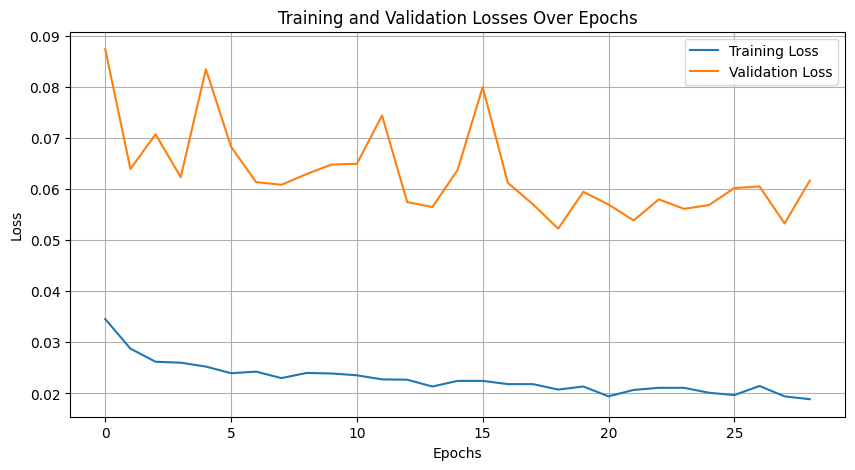

In [64]:
# Plotting the losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
if valid_losses:
    plt.plot(valid_losses, label='Validation Loss')
plt.title('Training and Validation Losses Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [103]:
for i in range(30,50):
    print(predictions[i])

[0.02455414 0.00951435]
[0.02185079 0.00951483]
[0.0182701  0.00955864]
[0.0040174 0.0383274]
[0.0451295  0.08844072]
[0.06391718 0.03548135]
[0.00472507 0.00435211]
[0.00077679 0.02664638]
[0.00264244 0.00614608]
[0.06962407 0.00661537]
[0.03157634 0.0092752 ]
[0.00457863 0.00518739]
[0.00371085 0.00517065]
[0.01153293 0.0252675 ]
[0.04802979 0.02157387]
[0.00278349 0.01421314]
[0.00165825 0.01180588]
[0.05860798 0.01316434]
[0.01578337 0.00929573]
[0.00231179 0.03485744]


# Evaluation

In [105]:
actual_counts[10000]

array([0., 0.], dtype=float32)

In [104]:
predicted_counts[10000]

array([0.05652633, 0.        ], dtype=float32)

In [509]:
def to_count(x):
    """predictions to integer counts"""
    # return np.rint(x).astype(int)   
    # rounded_predictions = np.where(x < 0.5, 0, np.rint(x).astype(int))
    # rounded_predictions = np.where(x < 0.3, 0, x)
    rounded_predictions = np.where(x < 0.5, 0, x)
    return rounded_predictions

def reverse_min_max_scale(scaled_data, data_min, data_max):
    """Reverses the min-max scaling applied to the data."""
    return (scaled_data * (data_max - data_min)) + data_min

def min_max_scale(data):
    data_min = np.min(data, axis=0)
    data_max = np.max(data, axis=0)
    return (data - data_min) / (data_max - data_min), data_min, data_max

scaled_features, features_min, features_max = min_max_scale(all_features_np)
scaled_targets, targets_min, targets_max = min_max_scale(target_np)

In [510]:
# get predictions and loss for test dataset
_, test_predictions = evaluate_model(model, test_loader, criterion, return_predictions=True, weight_non_zero=10)

MAE: 0.08680372
RMSE: 0.16868271
R-squared: 0.002443373203277588


In [511]:
# Calculate the number of sequences in the dataset
num_sequences = len(sequential_features)

# Calculate the split index
split_index = int(num_sequences * 0.9)  # 10% of the data for testing

In [512]:
# 'timestamp' is the first column and the rest are recorder counts
data.reset_index(inplace=True)
timestamps = data['timestamp']
test_timestamps = timestamps[split_index:-10]
len(test_timestamps)

23078

In [513]:
test_predictions[1]

array([0.24471664, 0.        ], dtype=float32)

ValueError: x and y must have same first dimension, but have shapes (23078,) and (5847,)

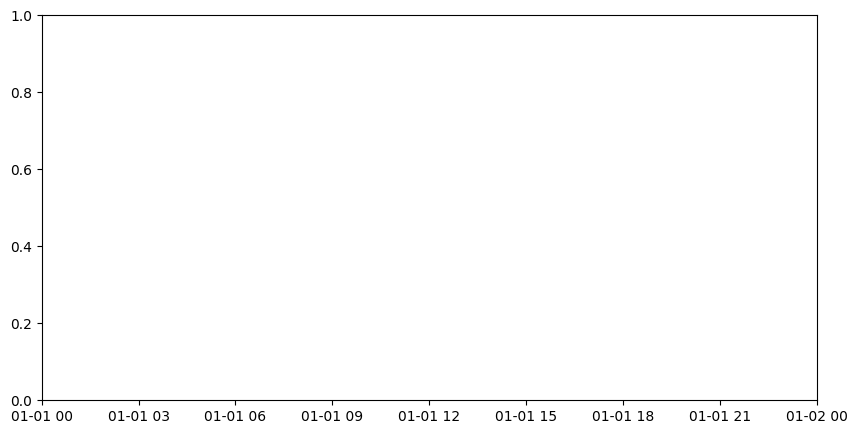

In [514]:
## import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Reverse scaling for both predictions and actual targets
actual_counts = reverse_min_max_scale(test_targets.numpy(), targets_min, targets_max)
predicted_counts = reverse_min_max_scale(test_predictions, targets_min, targets_max)
predicted_counts = to_count(predicted_counts)
        
plot_actual = actual_counts
plot_predicted = predicted_counts
plot_timestamp = test_timestamps

# plot_actual = actual_counts[1300:1600]
# plot_predicted = predicted_counts[1300:1600]
# plot_timestamp = test_timestamps[1300:1600]

# Plot actual vs. predicted for each recorder
for i in range(2):  # Assuming there are 6 recorders
    plt.figure(figsize=(10, 5))
    plt.plot(plot_timestamp, plot_actual[:, i], label='Actual', linewidth=1)
    plt.plot(plot_timestamp, plot_predicted[:, i], label='Predicted',linewidth=1)
    # plt.bar(range(data['timestamp'].index.size), actual_counts[:, i], label='Actual', width=1)
    # plt.xlim([data['timestamp'].min(), data['timestamp'].max()])

    plt.title(f'Recorder {i+1} Pedestrian Counts Over Time')
    plt.xlabel('Time')
    plt.ylabel('Pedestrian Count')
    
    plt.legend()
    plt.show()


In [614]:
# Assuming predicted_counts is your numpy array
np.save('5s_gcn_predicted_counts.npy', predicted_counts)  # Saves the array to a binary .npy file

# Assuming timestamps is your pandas Series
test_timestamps.to_csv('5s_gcn_test_timestamps.csv', index=False)  # Saves the timestamps to a CSV file

# Video Visuaslization

In [594]:
time = pd.DataFrame(test_timestamps)
time['timestamp'] = pd.to_datetime(time['timestamp'])

time_array = time['timestamp'].values
time_array

array(['2023-05-28T10:10:30.000000000', '2023-05-28T10:10:35.000000000',
       '2023-05-28T10:10:40.000000000', ...,
       '2023-05-28T20:41:05.000000000', '2023-05-28T20:41:10.000000000',
       '2023-05-28T20:41:15.000000000'], dtype='datetime64[ns]')

In [595]:
predicted_counts

array([[0.        , 0.        , 0.        , 0.05509366, 0.01946943,
        0.0613131 ],
       [0.        , 0.        , 0.00782323, 0.04772605, 0.0781949 ,
        0.30415678],
       [0.        , 0.        , 0.        , 0.05509366, 0.01946943,
        0.0613131 ],
       ...,
       [0.        , 0.01652236, 1.0985775 , 0.        , 0.22318627,
        1.3799591 ],
       [0.        , 0.00991423, 1.2442969 , 0.        , 0.2125949 ,
        1.4409792 ],
       [0.        , 0.        , 0.6453739 , 0.030255  , 0.15488808,
        0.8925381 ]], dtype=float32)

In [599]:
!pip install plotly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 8.1 MB/s eta 0:00:0000:0100:01


In [605]:
!pip install --upgrade nbformat

  Using cached jsonschema_specifications-2023.12.1-py3-none-any.whl.metadata (3.0 kB)
  Using cached referencing-0.35.1-py3-none-any.whl.metadata (2.8 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 2.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.5/88.5 kB 6.1 MB/s eta 0:00:00
Using cached jsonschema_specifications-2023.12.1-py3-none-any.whl (18 kB)
Using cached referencing-0.35.1-py3-none-any.whl (26 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.9/312.9 kB 5.7 MB/s eta 0:00:00a 0:00:01


In [607]:
import plotly
import plotly.graph_objects as go
import nbformat

locations = ['recorder1', 'recorder2', 'recorder3', 'recorder4', 'recorder5', 'recorder6']

fig = go.Figure(
    data=[go.Bar(x=locations, y=plot_predicted[0])],
    layout=go.Layout(
        title="Pedestrian Counts Over Time",
        updatemenus=[dict(
            type="buttons",
            buttons=[dict(label="Play",
                          method="animate",
                          args=[None, {"frame": {"duration": 500, "redraw": True},
                                       "fromcurrent": True, "transition": {"duration": 300, "easing": "quadratic-in-out"}}]),
                     dict(label="Pause",
                          method="animate",
                          args=[[None], {"frame": {"duration": 0, "redraw": False}, "mode": "immediate",
                                         "transition": {"duration": 0}}])
                     ])])
)

frames = [go.Frame(data=[go.Bar(x=locations, y=plot_predicted[i])], name=str(i*5)) for i in range(len(plot_predicted))]
fig.frames = frames
fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [612]:
import subprocess
import ffmpeg

locations = ['recorder1', 'recorder2', 'recorder3', 'recorder4', 'recorder5', 'recorder6']

plot_actual = actual_counts[1300:1600]
plot_predicted = predicted_counts[1300:1600]
plot_timestamp = time_array[1300:1600]

for index, counts in enumerate(plot_predicted):
    plt.figure(figsize=(10, 6))
    plt.bar(locations, counts, color='royalblue')
    plt.xlabel('Locations')
    plt.ylabel('Pedestrian Count')
    plt.title(f'Pedestrian Count at T={index*5} seconds')
    plt.ylim(0, predicted_counts.max() + 0.5)  # Adjust as necessary
    plt.savefig(f'./frames/frame_{index:04d}.png')
    plt.close()
    
# Define the command as a string
command = "ffmpeg -framerate 1 -i ./frames/frame_%04d.png -c:v libx264 -profile:v high -crf 20 -pix_fmt yuv420p ./output/output.mp4"

# Use subprocess to execute the commanda
subprocess.run(command, shell=True)

/bin/sh: ffmpeg: command not found


CompletedProcess(args='ffmpeg -framerate 1 -i ./frames/frame_%04d.png -c:v libx264 -profile:v high -crf 20 -pix_fmt yuv420p ./output/output.mp4', returncode=127)

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import pandas as pd
import os

# Sample data
data = pd.DataFrame({
    'Time': time_array,
    'Loc1': [10, 20, 15],
    'Loc2': [20, 15, 10],
    # Add other locations
})

# Coordinates of locations
locations = {
    'Loc1': (longitude1, latitude1),
    'Loc2': (longitude2, latitude2),
    # Add other locations
}

# Create plots for each time step
for index, row in data.iterrows():
    fig, ax = plt.subplots()
    m = Basemap(projection='merc', llcrnrlat=-80, urcrnrlat=80, llcrnrlon=-180, urcrnrlon=180, lat_ts=20, resolution='c', ax=ax)
    m.drawcoastlines()

    # Plot each location
    for loc, (lon, lat) in locations.items():
        x, y = m(lon, lat)
        size = row[loc]  # Assuming the count affects the size of the dot
        m.scatter(x, y, s=size, label=f'{loc}: {size}')

    plt.legend()
    plt.title(f'Time: {row["Time"]}')
    plt.savefig(f'frame_{index}.png')
    plt.close()

# Convert to GIF using ImageMagick (run this command in the same directory where your images are saved)
os.system('convert -delay 20 -loop 0 frame_*.png animation.gif')
